In [80]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primal_VPINN import *
from NN_library.train_dual_VPINN import *
from matplotlib.tri import Triangulation
from utility import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
data = dataset_grid(129, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 129**2)

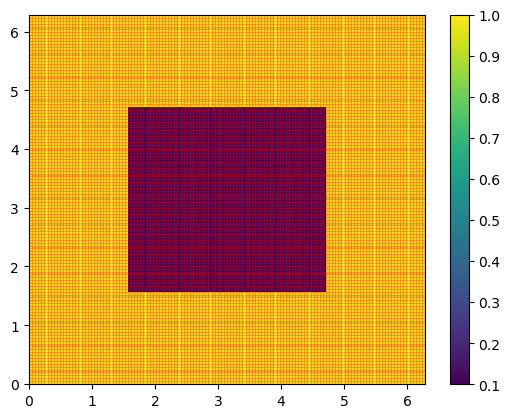

In [82]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)
eps=100

def a_function(x,y):
    a = np.where((x>np.pi/2)&(x<3*np.pi/2)&(y>np.pi/2)&(y<3*np.pi/2), 0.1, 1)
    return a

def A(x):
    a = torch.where((x[:,0]>torch.pi/2)&(x[:,0]<3*torch.pi/2)&(x[:,1]>torch.pi/2)&(x[:,1]<3*torch.pi/2), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A_inv(x):  
    a = torch.where((x[:,0]>torch.pi/2)&(x[:,0]<3*torch.pi/2)&(x[:,1]>torch.pi/2)&(x[:,1]<3*torch.pi/2), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a) * I
    return A

def A_interp(x): 
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a.view(-1,1,1) * I
    return A

def A_interp_inv(x):  
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = 1/a.view(-1,1,1) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(), XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.1, c='r')

# Test functions

## NN-based

In [90]:
N_test = 200
torch.manual_seed(0)
test_functions = [PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L).to(dev) for i in range(N_test)]

In [38]:
# compute G if needed
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(dev)
x = x.to(dev).requires_grad_(True)

G = torch.zeros((N_test, N_test))
g_test = []
for i in range(N_test):
    y_test = test_functions[i](x)
    grad_test = torch.autograd.grad(
                outputs=y_test, inputs=x,
                grad_outputs=torch.ones_like(y_test)
            )[0]
    g_test.append(grad_test.detach())

#for i in range(N_test):
    #for j in range(i, N_test):
        #intgr = compute_int(areas, tri, g_test[i], g_test[j])
        #G[i,j] = intgr
        #G[j,i] = intgr

for i in range(N_test):
        intgr = compute_int(areas, tri, g_test[i], g_test[i]).detach()
        G[i,i] = intgr

torch.save(G, "G_primal_65.pt")
G_inv = torch.linalg.inv(G).to(dev)

In [9]:
G = torch.load("G_primal_65.pt")[:N_test,:N_test]
G_inv = torch.linalg.inv(G).to(dev)

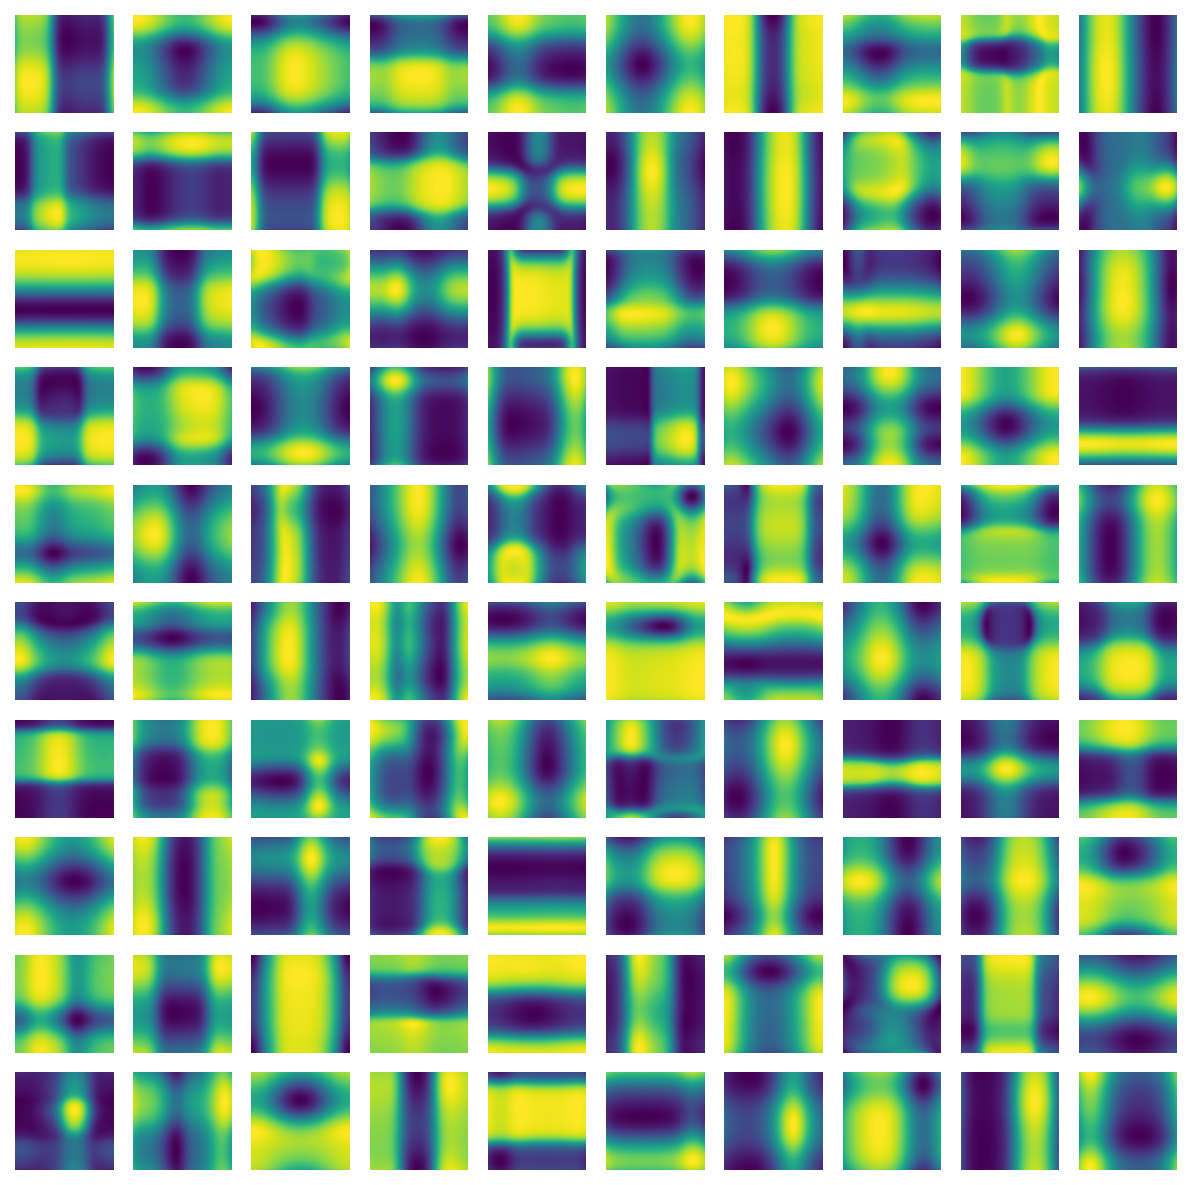

In [14]:
fig, axs = plt.subplots(nrows=10, ncols=N_test//10, figsize=(N_test//10,10), dpi=150)
for i in range(len(test_functions)):
    axs.flat[i].pcolormesh(XY[0], XY[1], test_functions[i](grid_data).reshape(N, N).cpu().detach())
    axs.flat[i].set_axis_off()

# Primal PINN

In [91]:
net_primal = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
total_params = sum(p.numel() for p in net_primal.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 1e-4, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VNPINN_primal_{total_params}_{N_test}'}

Number of parameters: 65


In [92]:
net_primal = load_network(net_primal, args['name']+'_39999', args)
net_primal = net_primal.to(dev)

In [43]:
losses_train, losses_val = train_primal(net_primal, loaders, args, A_interp, H1, test_functions, G_inv, L)

Epoch: 0 mean train loss:  1.63406887e+01, mean val. loss:  7.90957212e-01
Epoch: 1 mean train loss:  1.63284111e+01, mean val. loss:  7.90899515e-01
Epoch: 2 mean train loss:  1.63161602e+01, mean val. loss:  7.90841818e-01
Epoch: 3 mean train loss:  1.63039398e+01, mean val. loss:  7.90784359e-01
Epoch: 4 mean train loss:  1.62917480e+01, mean val. loss:  7.90727019e-01
Epoch: 5 mean train loss:  1.62795868e+01, mean val. loss:  7.90669799e-01
Epoch: 6 mean train loss:  1.62674580e+01, mean val. loss:  7.90612698e-01
Epoch: 7 mean train loss:  1.62553596e+01, mean val. loss:  7.90555775e-01
Epoch: 8 mean train loss:  1.62432919e+01, mean val. loss:  7.90499032e-01
Epoch: 9 mean train loss:  1.62312546e+01, mean val. loss:  7.90442348e-01
Epoch: 10 mean train loss:  1.62192535e+01, mean val. loss:  7.90385962e-01
Epoch: 11 mean train loss:  1.62072830e+01, mean val. loss:  7.90329576e-01
Epoch: 12 mean train loss:  1.61953449e+01, mean val. loss:  7.90273368e-01
Epoch: 13 mean train l

In [44]:
np.save(f'NN_library/training_data/square/VNPINN_primal_{total_params}_{N_test}', np.vstack([losses_train, losses_val]))

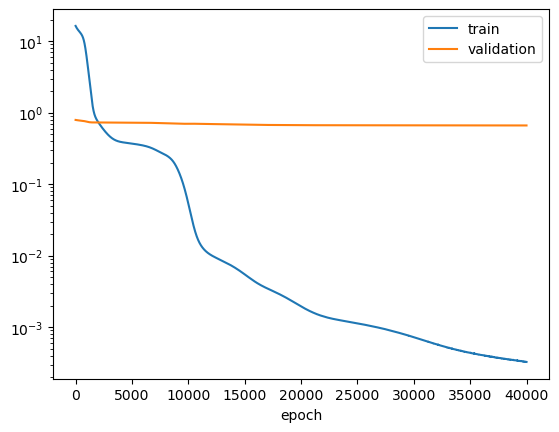

In [45]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [49]:
U1 = net_primal(grid_data).detach().cpu()
error_1, _, _ = PDE_loss(grid_data, net_primal, A_interp, H1)

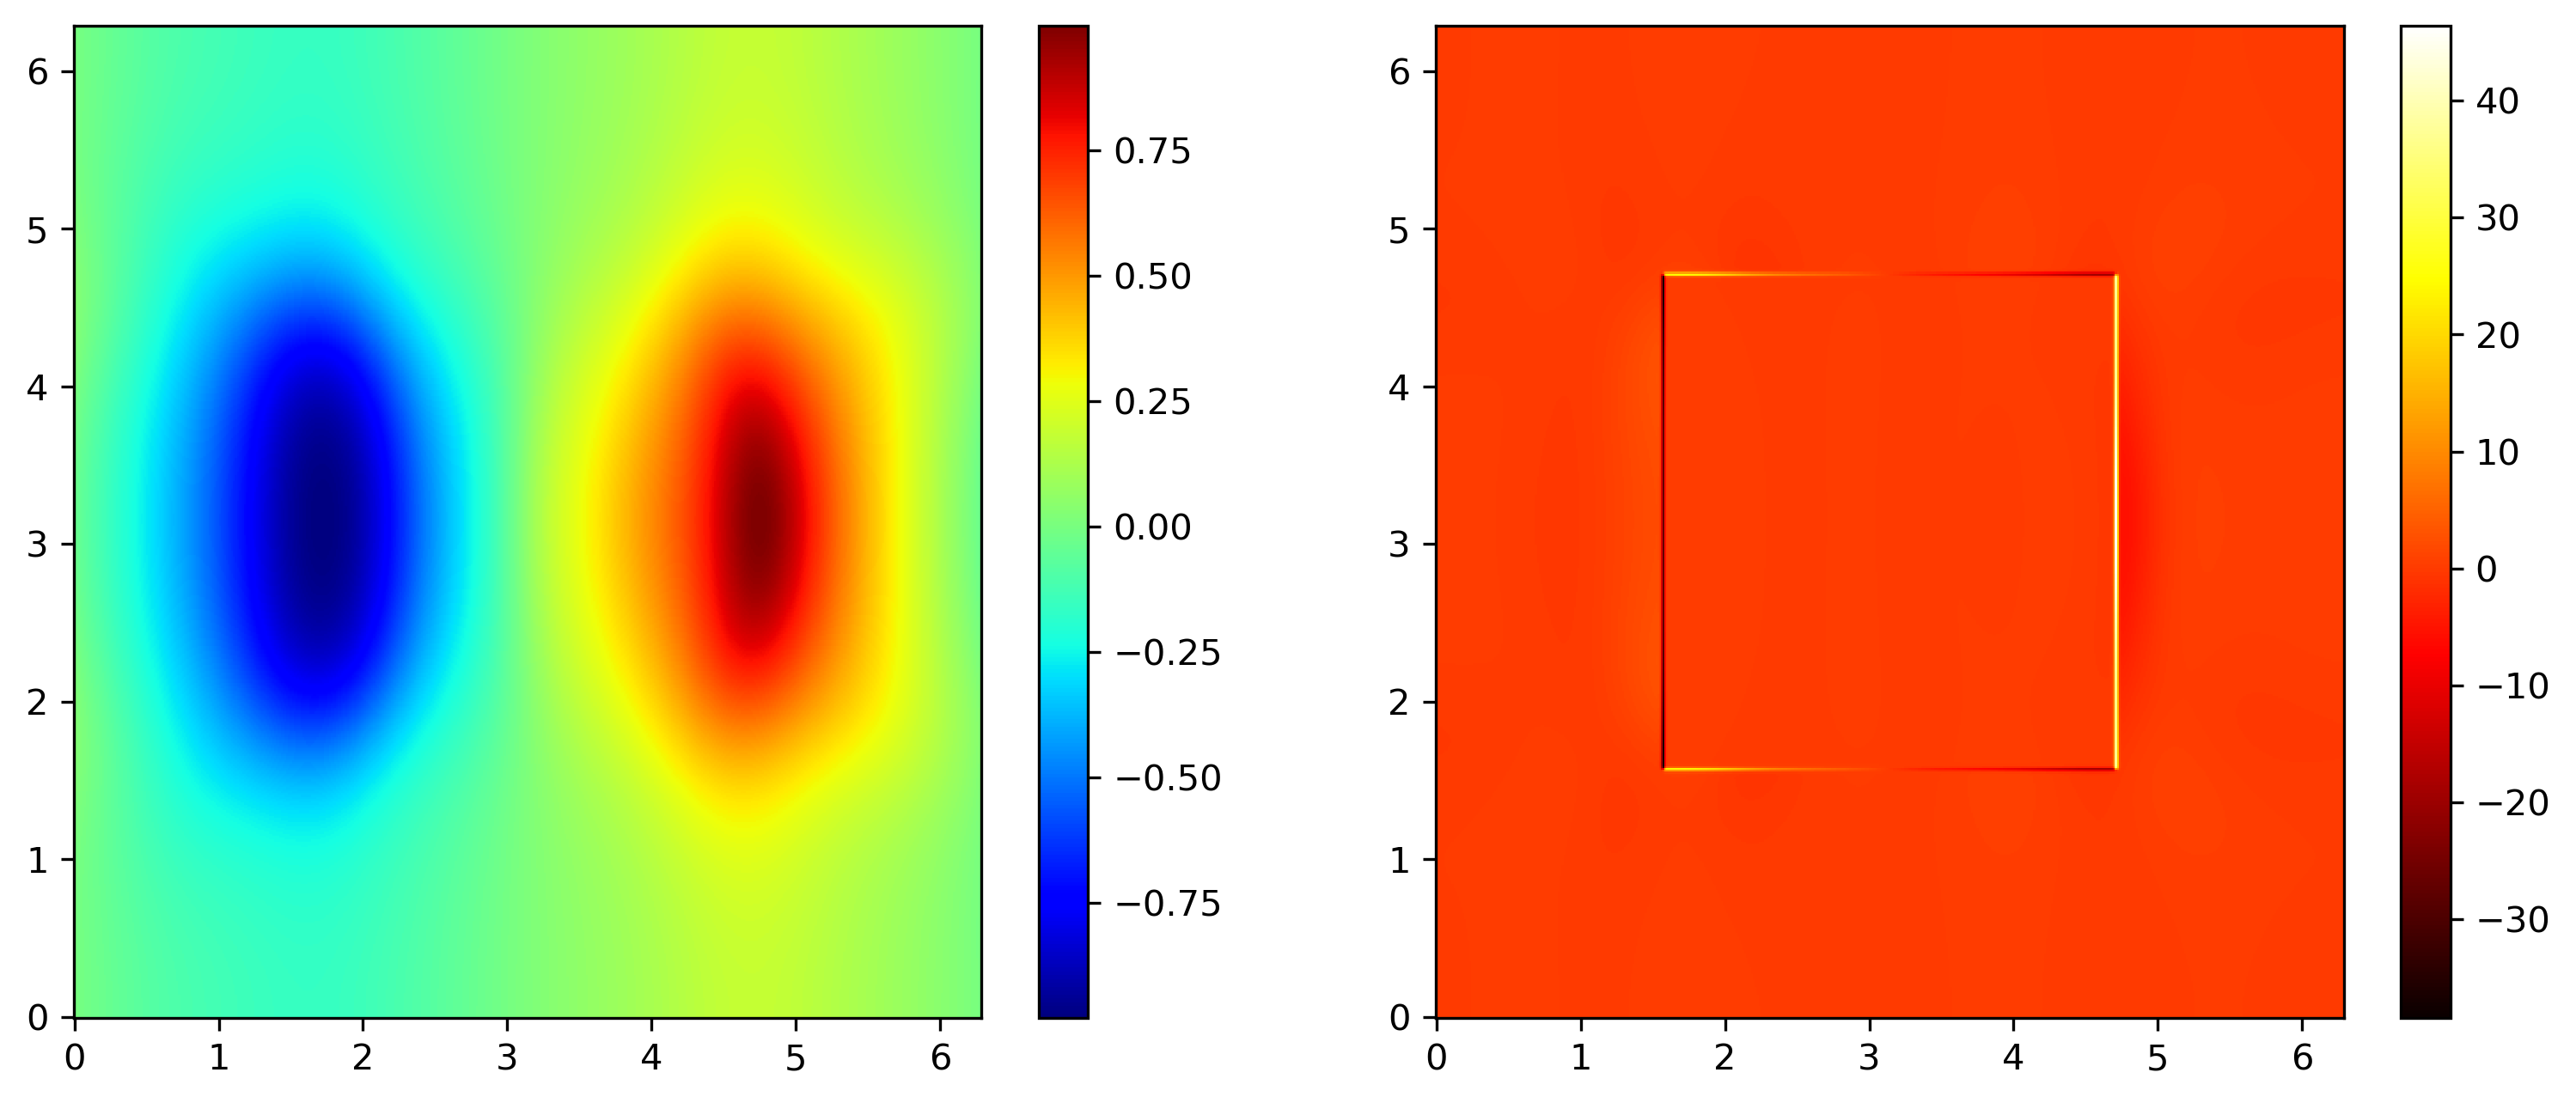

In [51]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='jet')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.detach().cpu().reshape(N, N), cmap='seismic')
fig.colorbar(pos2, ax=axs[1])

In [93]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])
x_rot = torch.fliplr(x)

_, q1, gH = PDE_loss(x, net_primal, A_interp, H1)
bound_1 = compute_estimate(areas, tri, q1, gH, L).detach().item()
print(bound_1)

U1 = net_primal(x)
U2 = net_primal(x_rot)
bound_2 = compute_bound_primal(U1, U2, tri, x, A, L)[0,0]
print(bound_2)

np.save(f'bounds/square/A_u_VNPINN_{total_params}_{N_test}.npy', (bound_1, bound_2))

0.6600229144096375
0.6599127050765672


# Dual PINN

In [87]:
net_dual = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
total_params = sum(p.numel() for p in net_dual.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VNPINN_dual_{total_params}_{N_test}'}

Number of parameters: 65


In [88]:
net_dual = load_network(net_dual, args['name']+'_39999', args)
net_dual = net_dual.to(dev)

In [74]:
losses_train, losses_val = train_dual(net_dual, loaders, args, A_interp_inv, H1, test_functions, G_inv, L)

Epoch: 0 mean train loss:  1.71271423e+03, mean val. loss:  2.57148445e-01
Epoch: 1 mean train loss:  1.71106238e+03, mean val. loss:  2.57255703e-01
Epoch: 2 mean train loss:  1.70941309e+03, mean val. loss:  2.57362932e-01
Epoch: 3 mean train loss:  1.70776709e+03, mean val. loss:  2.57469982e-01
Epoch: 4 mean train loss:  1.70612402e+03, mean val. loss:  2.57576883e-01
Epoch: 5 mean train loss:  1.70448364e+03, mean val. loss:  2.57683724e-01
Epoch: 6 mean train loss:  1.70284668e+03, mean val. loss:  2.57790327e-01
Epoch: 7 mean train loss:  1.70121301e+03, mean val. loss:  2.57896781e-01
Epoch: 8 mean train loss:  1.69958203e+03, mean val. loss:  2.58003145e-01
Epoch: 9 mean train loss:  1.69795459e+03, mean val. loss:  2.58109272e-01
Epoch: 10 mean train loss:  1.69633032e+03, mean val. loss:  2.58215219e-01
Epoch: 11 mean train loss:  1.69470898e+03, mean val. loss:  2.58320987e-01
Epoch: 12 mean train loss:  1.69309106e+03, mean val. loss:  2.58426547e-01
Epoch: 13 mean train l

In [75]:
np.save(f'NN_library/training_data/square/VNPINN_dual_{total_params}_{N_test}', np.vstack([losses_train, losses_val]))

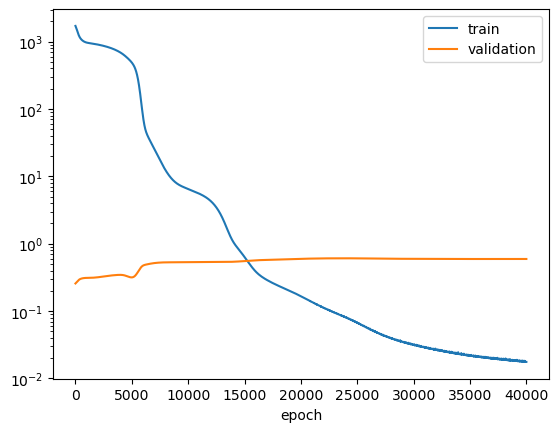

In [76]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [77]:
U2 = net_dual(grid_data).detach().cpu()
error_2, _, _ = PDE_loss_dual(grid_data, net_dual, A_interp_inv, H1)

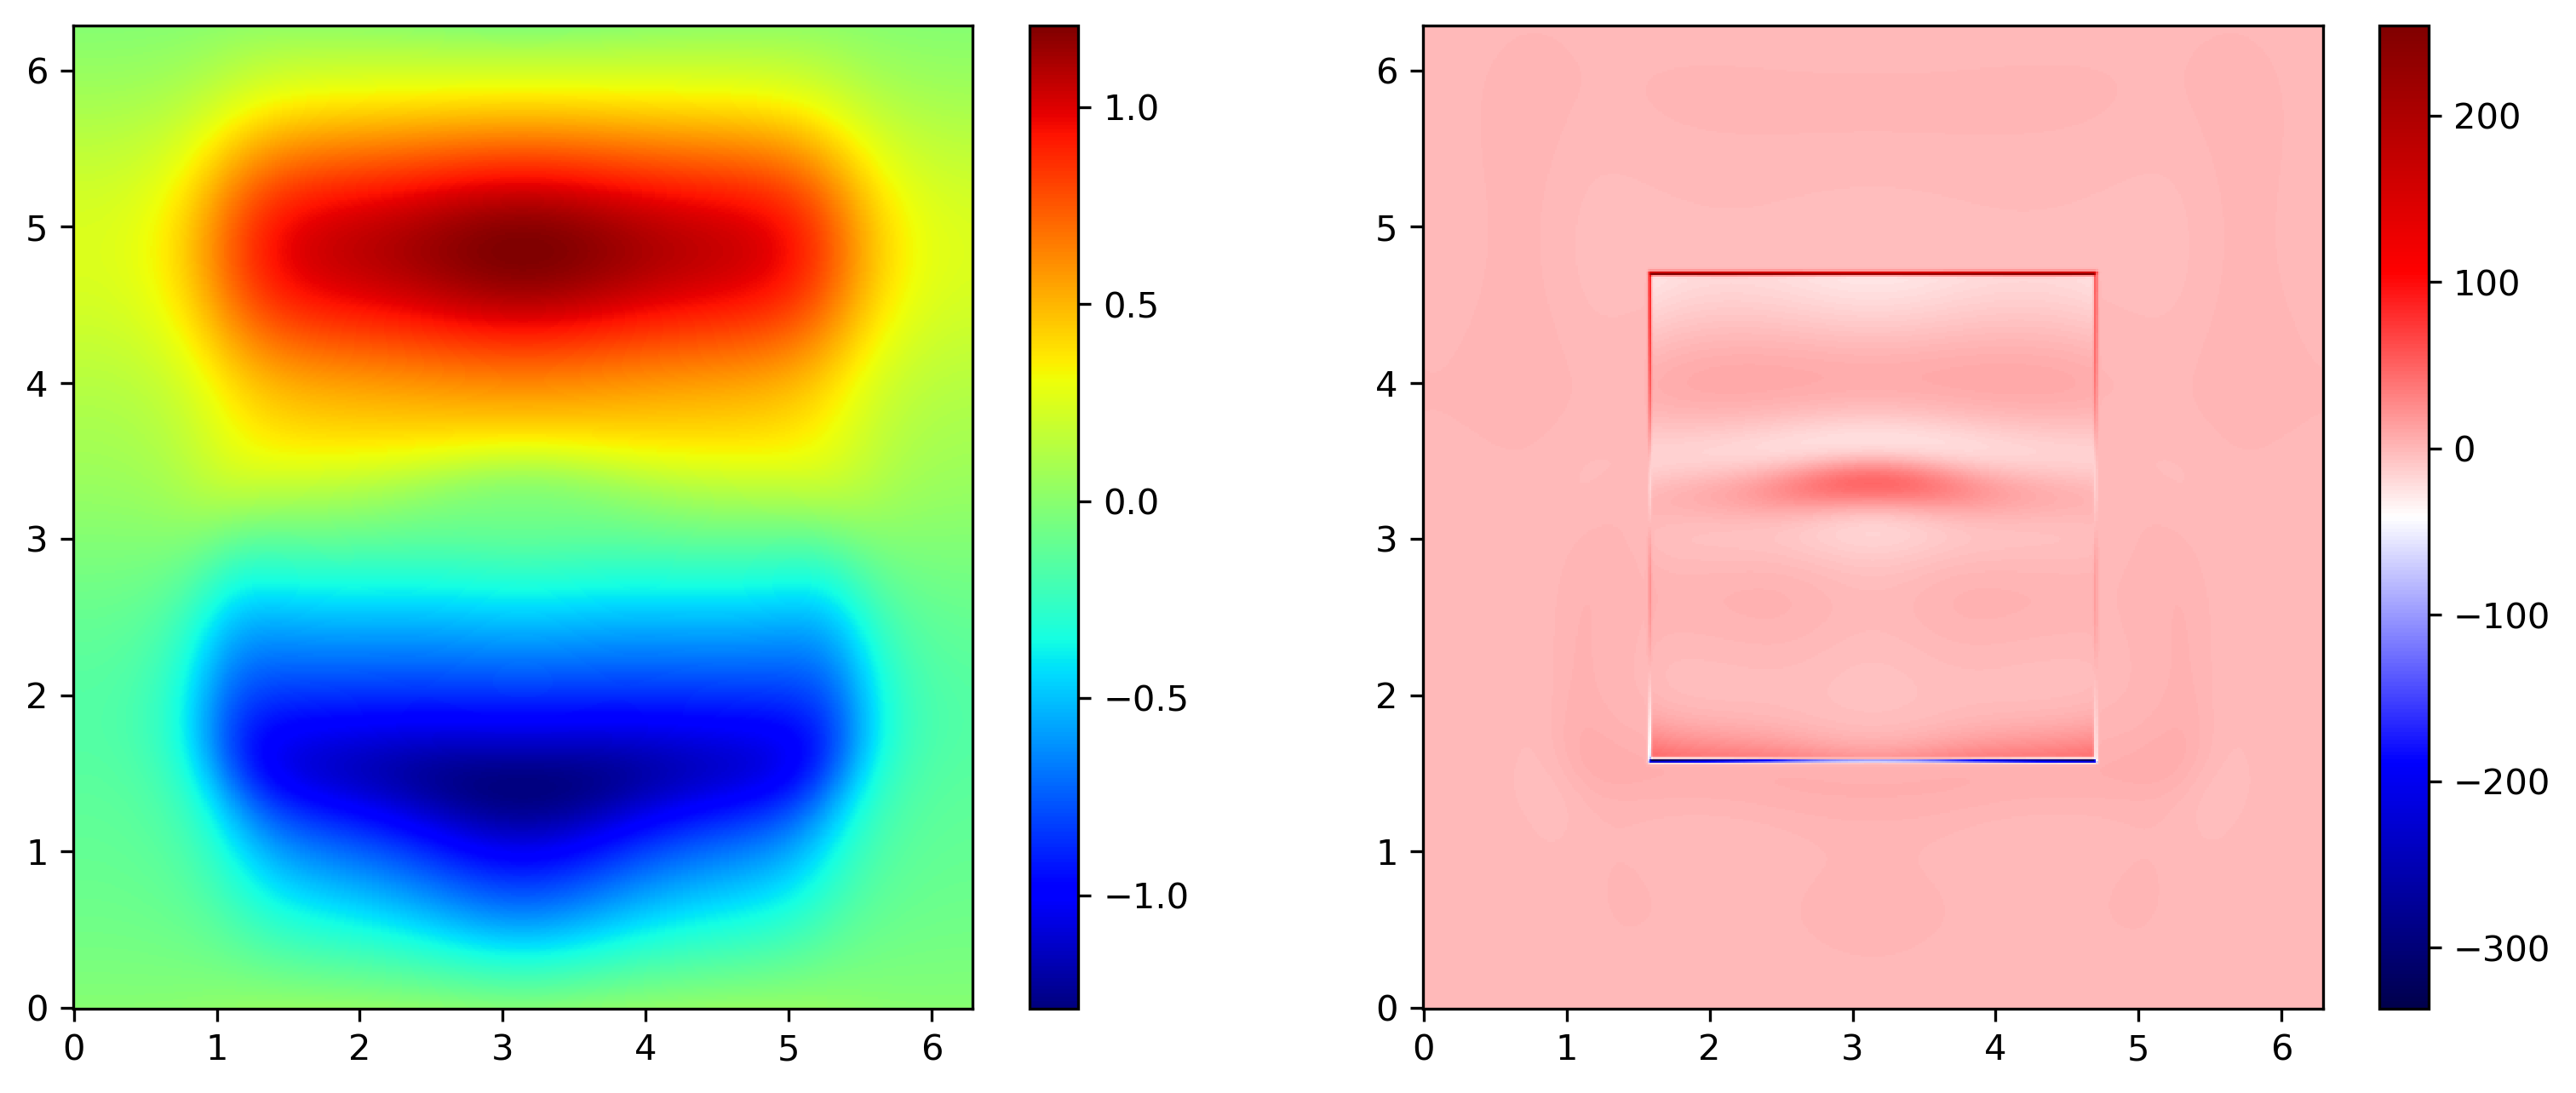

In [78]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U2.reshape(N, N), cmap='jet')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='seismic')
fig.colorbar(pos2, ax=axs[1])

In [94]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])
x_rot = torch.fliplr(x)
x_rot[:,1] = -x_rot[:,1]

_, q2, gH = PDE_loss_dual(x, net_dual, A_interp_inv, H1)
bound_1 = compute_estimate(areas, tri, q2, gH, L).detach().item()
print(1/bound_1)

W1 = net_dual(x)
W2 = net_dual(x_rot)

bound_2 = compute_bound_dual(W1, W2, tri, x, A_inv, L)[0,0]
print(bound_2)

np.save(f'bounds/square/A_l_VNPINN_{total_params}_{N_test}.npy', (1/bound_1, bound_2))

0.6159180967601223
0.6082742175461118


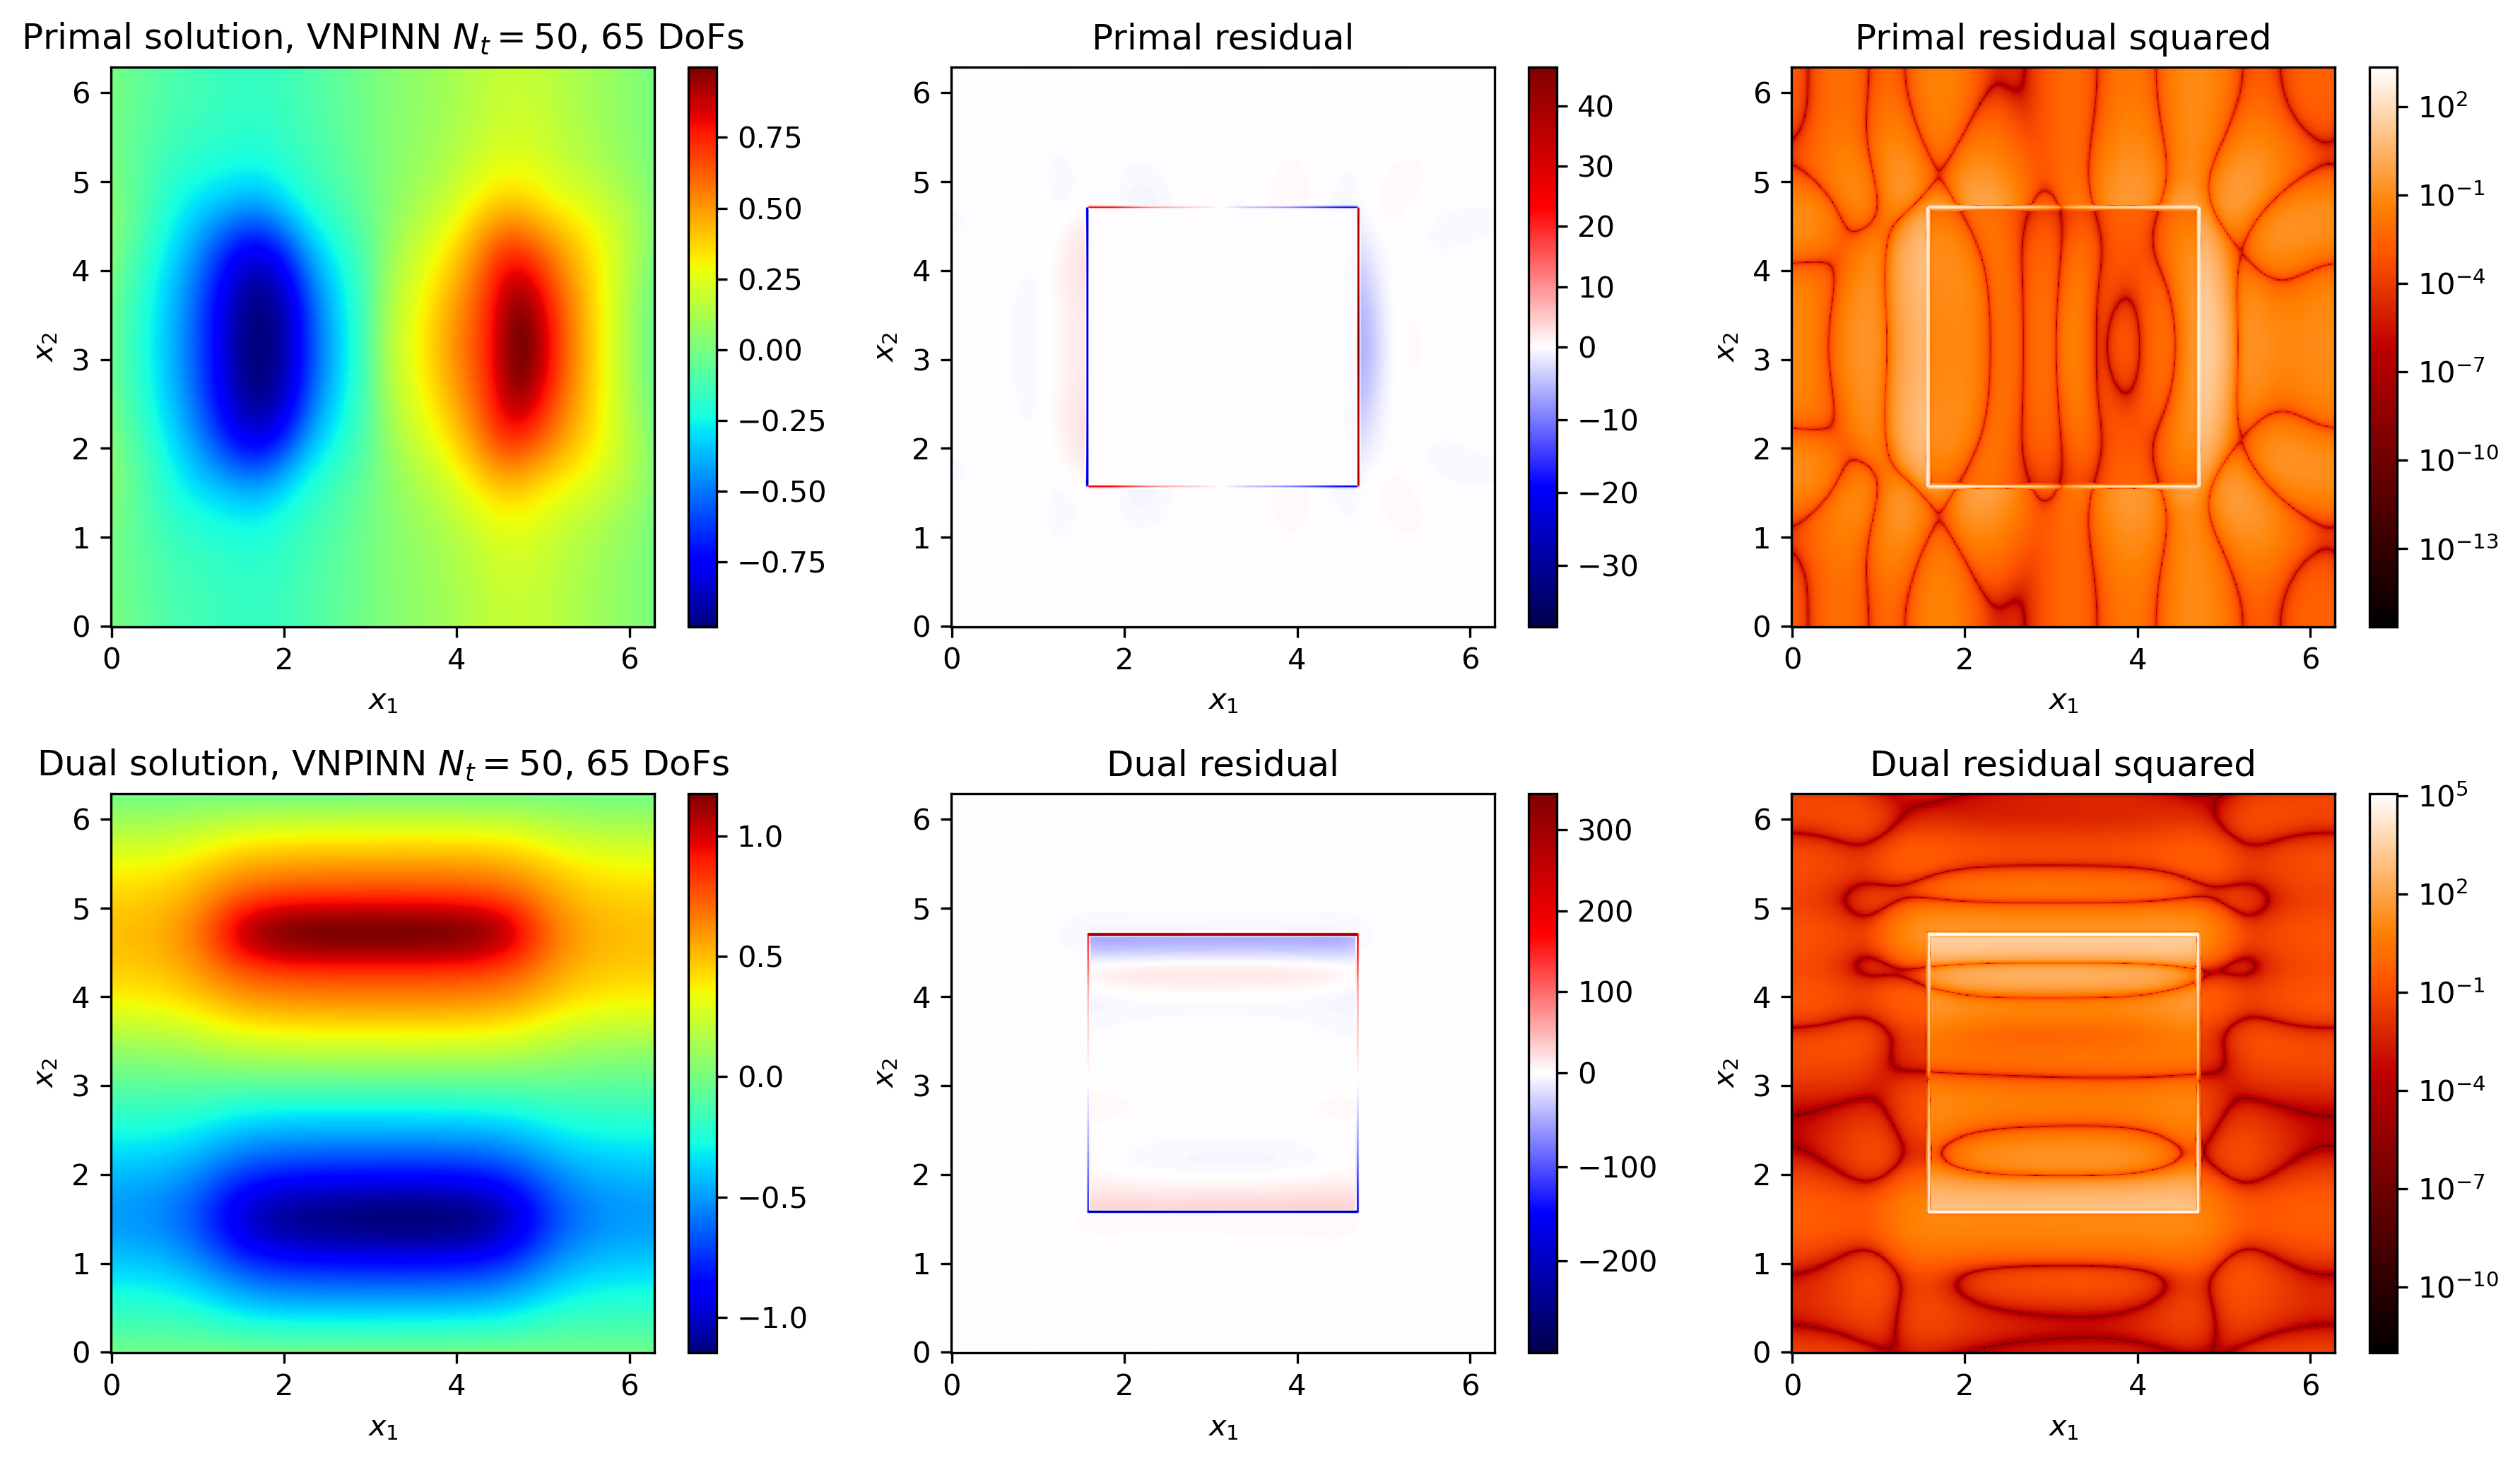

In [68]:
U1 = net_primal(grid_data).detach().cpu().reshape(N, N)
error_1_p, _, _ = PDE_loss(grid_data, net_primal, A_interp, H1)
error_1_p = error_1_p.detach().cpu().reshape(N, N)
U2 = net_dual(grid_data).detach().cpu().reshape(N, N)
error_1_d, _, _ = PDE_loss_dual(grid_data, net_dual, A_interp_inv, H1)
error_1_d = error_1_d.detach().cpu().reshape(N, N)

from matplotlib.colors import TwoSlopeNorm, LogNorm

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,7), dpi=300)

for i in range(6):
    axs.flat[i].set_xlabel('$x_1$')
    axs.flat[i].set_ylabel('$x_2$')

pos1 = axs[0,0].pcolormesh(XY[0], XY[1], U1, cmap='jet')
fig.colorbar(pos1, ax=axs[0,0])
pos2 = axs[1,0].pcolormesh(XY[0], XY[1], U2, cmap='jet')
fig.colorbar(pos2, ax=axs[1,0])

axs[0,0].set_title(f'Primal solution, VNPINN $N_t=50$, {total_params} DoFs')
axs[1,0].set_title(f'Dual solution, VNPINN $N_t=50$, {total_params} DoFs')


pos1 = axs[0,1].pcolormesh(XY[0], XY[1], error_1_p, cmap='seismic', norm=TwoSlopeNorm(vmin=error_1_p.min(), vcenter=0, vmax=error_1_p.max()))
fig.colorbar(pos1, ax=axs[0,1])
pos2 = axs[1,1].pcolormesh(XY[0], XY[1], error_1_d, cmap='seismic', norm=TwoSlopeNorm(vmin=error_1_d.min(), vcenter=0, vmax=error_1_d.max()))
fig.colorbar(pos2, ax=axs[1,1])

axs[0,1].set_title('Primal residual')
axs[1,1].set_title('Dual residual')

pos1 = axs[0,2].pcolormesh(XY[0], XY[1], error_1_p**2, cmap='gist_heat', norm=LogNorm(vmin=(error_1_p**2).min(), vmax=(error_1_p**2).max()))
fig.colorbar(pos1, ax=axs[0,2])
pos2 = axs[1,2].pcolormesh(XY[0], XY[1], error_1_d**2, cmap='gist_heat', norm=LogNorm(vmin=(error_1_d**2).min(), vmax=(error_1_d**2).max()))
fig.colorbar(pos2, ax=axs[1,2])

axs[0,2].set_title('Primal residual squared')
axs[1,2].set_title('Dual residual squared')
plt.tight_layout()